In [1]:
#Adding last modified date
from datetime import datetime
from IPython.display import display, Markdown
todays_date = str(datetime.now().date())
time = str(str(datetime.now().time()))
author = "Keerthana Arun"
display(Markdown(f'Last modified on {todays_date} at {time} by {author}'))

Last modified on 2025-02-19 at 16:22:57.933937 by Keerthana Arun

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import sys
# sys.path.insert(0, '/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/KeerthanaArun/grnInference/grnSimulationSetup/src/')
from graphGenerator import generateGraph, generateGraphDag, visualizeGraphs
import graphGenerator
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import qmc
from sympy import symbols, simplify, parse_expr
from sympy.core.sympify import SympifyError  # Correctly import SympifyError
import re

## To build a number of networks with a fixed number of nodes

### Code to build the network

In [3]:
def main(n, numEdges, numGraphs, baseSeed):
    """
    Execute the graph generation process in parallel, aiming to collect a specified number of unique graphs
    based on their canonical forms. It visualizes the resultant graphs and returns a list of these unique graphs.

    Parameters
    ----------
    n : int
        The number of nodes in each graph.
    numEdges : int
        The number of edges to be present in the graph
    numGraphs : int
        The target number of unique graphs to generate.
    baseSeed : int
        The base seed for random number generation, which is incremented for each graph generation attempt
        to ensure diversity in the generated graphs.

    Returns
    -------
    graphs : list
        A list of unique graphs that have been generated and verified as unique based on their canonical forms.

    Processes
    ----------
    - Utilizes a process pool to execute graph generation tasks in parallel.
    - Monitors the progress of graph generation using a tqdm progress bar.
    - Continues graph generation until the desired number of unique graphs is reached.
    - After reaching the target number, visualizes the generated graphs.

    Note
    ----
    The canonical form is used to ensure uniqueness among the generated graphs. The function uses a set to keep
    track of canonical forms already generated. Graph generation stops either when the number of unique graphs
    meets the specified target or when the specified number of attempts is exhausted.
    """
    canonical_forms = set() 
    graphs = []
    
    with ProcessPoolExecutor() as executor:
    # Submit tasks and collect futures
        futures = [executor.submit(generateGraph, n, numEdges, baseSeed + i, numGraphs * 100) for i in range(numGraphs * 100)]
    
        # Iterate over futures as they complete, while displaying progress with tqdm
        for future in tqdm(futures, total=len(futures)):
            graph, canonical_form = future.result()
            if canonical_form not in canonical_forms and len(graphs) < numGraphs:
                canonical_forms.add(canonical_form)
                graphs.append(graph)
            if len(graphs) >= numGraphs:
                break

    # Visualize the graphs
    visualizeGraphs(graphs)  # Visualizing only the first 5 graphs

    # Return the list of unique graphs
    return graphs

In [4]:
def createLinearGraph(n):
    """
    Execute the graph generation process in parallel, aiming to collect a specified number of unique graphs
    based on their canonical forms. It visualizes the resultant graphs and returns a list of these unique graphs.

    Parameters
    ----------
    n : np.array
        An array of number of nodes in each graph

    Returns
    -------
    graphs : list
        A list of unique graphs that have been generated and verified as unique based on their canonical forms.

    """
    graphs = []
    canonical_forms = set() 

    for numNodes in n:
        graph, canonical_form = generateGraph(numNodes)
        if canonical_form not in canonical_forms:
                canonical_forms.add(canonical_form)
                graphs.append(graph)
    visualizeGraphs(graphs)    
    # Return the list of unique graphs
    return graphs

### Function to write reactions based off the graphs

In [5]:
# Define symbols for parameters
rOn, rOff, d, rProd = symbols('rOn rOff d rProd')

def regexReplace(expression, old, new):
    # Wrap the old symbol in word boundaries to ensure complete matches
    pattern = r'\b' + re.escape(old) + r'\b'
    # Replace all instances in the expression
    return re.sub(pattern, new, expression)

def preciseRestore(expression):
    # Dictionary of replacements with complete symbol names
    replacements = {
        'rOn': '{rOn}', 'rOff': '{rOff}', 'd': '{d}', 'rProd': '{rProd}', 'rDeg': '{rDeg}', 
        'k': '{k}', 'n': '{n}', 'rAdd': '{rAdd}'
    }

    for old, new in replacements.items():
        expression = regexReplace(expression, old, new)

    # Replace 'g_' back to 'g-' for species identifiers
    expression = expression.replace('g_', 'g-')

    return expression

def simplifyAndRestore(expression):
    try:
        # Prepare the expression for sympy
        expression = expression.replace('{', '').replace('}', '').replace('g-', 'g_')
        expr = parse_expr(expression, evaluate=False)
        simplified = simplify(expr)

        # Precisely restore the original formatting
        restoredExpression = preciseRestore(str(simplified))
        return restoredExpression
    except SympifyError as e:
        print(f"Error sympifying expression: {expression}. Error: {e}")
        return expression
    except Exception as e:
        print(f"General error with expression: {expression}. Error: {e}")
        return expression

In [6]:
#Defining propensity when a gene is activated by mRNA from a different gene
activationGeneralPropensity = "({rAdd}*(activator_mRNA**{n})/({k}**{n} + activator_mRNA**{n}))*gene_I"
#Defining propensity when a gene is activated from the inactive state of same gene with no activator molecules present
activationOnlyPropensity = "{rOn}*gene_I"
#Defining propensity when a gene is inactivated
inactivationGeneralPropensity = "{rOff}*gene_A"
#Defining propensity from mRNA production when is the corresponding gene is active
mrnaProductionActivated = "{d}*{rProd}*gene_A"
#Defining propensity from mRNA production when is the corresponding gene is inactive
mrnaProductionInactivated = "{rProd}*gene_I"
#Defining propensity when an mRNA molecule is degraded
degradationGeneralPropensity = "{rDeg}*gene_mRNA"

def prepareReactions(DG):
    geneList = DG.nodes
    reactionList = []
    
    for gene in geneList:
        propensities = []

        #The propensity of the gene activating without any activators
        activationDirectPropensity = activationOnlyPropensity.replace("gene", gene)
        propensities.append(activationDirectPropensity)
        entry = {"species1": gene + "_A", "change1": 1, "propensity": activationDirectPropensity, "species2": gene + "_I", "change2":-1}
        reactionList.append(entry)

        #Parsing through all the activating genes for this gene based on the directed edges in the graph and adding that to the reaction list 
        for edge in DG.in_edges(gene, data = True):
            activationPropensity = activationGeneralPropensity.replace('activator', edge[0])
            activationPropensity = activationPropensity.replace('gene', gene)       

            #Creating reactions: Species one is the one that is created in this step and the Change1 is +1 to its population. Species2 is the entity that is consumed in the reaction and hnece change2 is -1. Basically, there are two entities involved in this reaction.
            entry = {"species1": gene + "_A", "change1": 1, "propensity": activationPropensity, "species2": gene + "_I", "change2":-1}
            reactionList.append(entry)
        
        #Propensity for Inactivation of gene
        inactivationPropensity = inactivationGeneralPropensity.replace("gene", gene)
        entry = {"species1": gene + "_I", "change1": 1, "propensity": inactivationPropensity, "species2": gene + "_A", "change2":-1}
        reactionList.append(entry)

        #Propensity for production of mRNA from a gene in activated or inactivated state
        productionPropensityActivated = mrnaProductionActivated.replace("gene", gene)
        entry = {"species1": gene + "_mRNA", "change1": 1, "propensity": productionPropensityActivated, "species2": "-", "change2":"-"}
        reactionList.append(entry)

        productionPropensityInactivated = mrnaProductionInactivated.replace("gene", gene)
        entry = {"species1": gene + "_mRNA", "change1": 1, "propensity": productionPropensityInactivated, "species2": "-", "change2":"-"}
        reactionList.append(entry)

        #Propensity for degradation of mRNA
        degradationPropensity = degradationGeneralPropensity.replace("gene", gene)
        entry = {"species1": gene + "_mRNA", "change1": -1, "propensity": degradationPropensity, "species2": "-", "change2":"-"}
        reactionList.append(entry)

    reactionDF = pd.DataFrame(reactionList)
    
    reactionDF['time'] = pd.Series(["-"] * len(reactionDF))
    aggregated = reactionDF.groupby(['species1', 'change1', 'species2', 'change2', 'time'])['propensity'].apply(lambda x: ' + '.join(x)).reset_index()

    # Apply simplification and format restoration
    aggregated['propensity'] = aggregated['propensity'].apply(lambda x: simplifyAndRestore(x))
    return aggregated

### Creating initial state

In [7]:
def prepareInitialState(geneList):
    stateList = []
    for gene in geneList:
        activatedSpecies = {"species": gene + "_A", "count":0}
        inactivatedSpecies = {"species": gene + "_I", "count":1}
        mRNASpecies = {"species": gene + "_mRNA", "count":0}
        stateList.append(activatedSpecies)
        stateList.append(inactivatedSpecies)
        stateList.append(mRNASpecies)

    stateListDF = pd.DataFrame(stateList)
    return stateListDF

### Function save graphs

In [8]:
def saveGraphsAsGml(graph, directory="Graphs"):
    networks_dir = os.path.join(directory, "networks")
    reactions_dir = os.path.join(directory, "reactions")
    os.makedirs(networks_dir, exist_ok=True)
    os.makedirs(reactions_dir, exist_ok=True)

    # Iterate through the list of graphs
    # Construct the filename using the number of edges and the index of the graph
    fileName = f"graph{len(graph.nodes())}"
    graphPath = os.path.join(networks_dir, fileName + ".gml")
    reactionPath = os.path.join(reactions_dir, "reactions.csv")
    # Prepare and save reactions data for the graph
    reactionsDf = prepareReactions(graph)
    reactionsDf.to_csv(reactionPath, index=False)
    # Save the graph to the specified file as GML
    nx.write_gml(graph, graphPath)

### Main

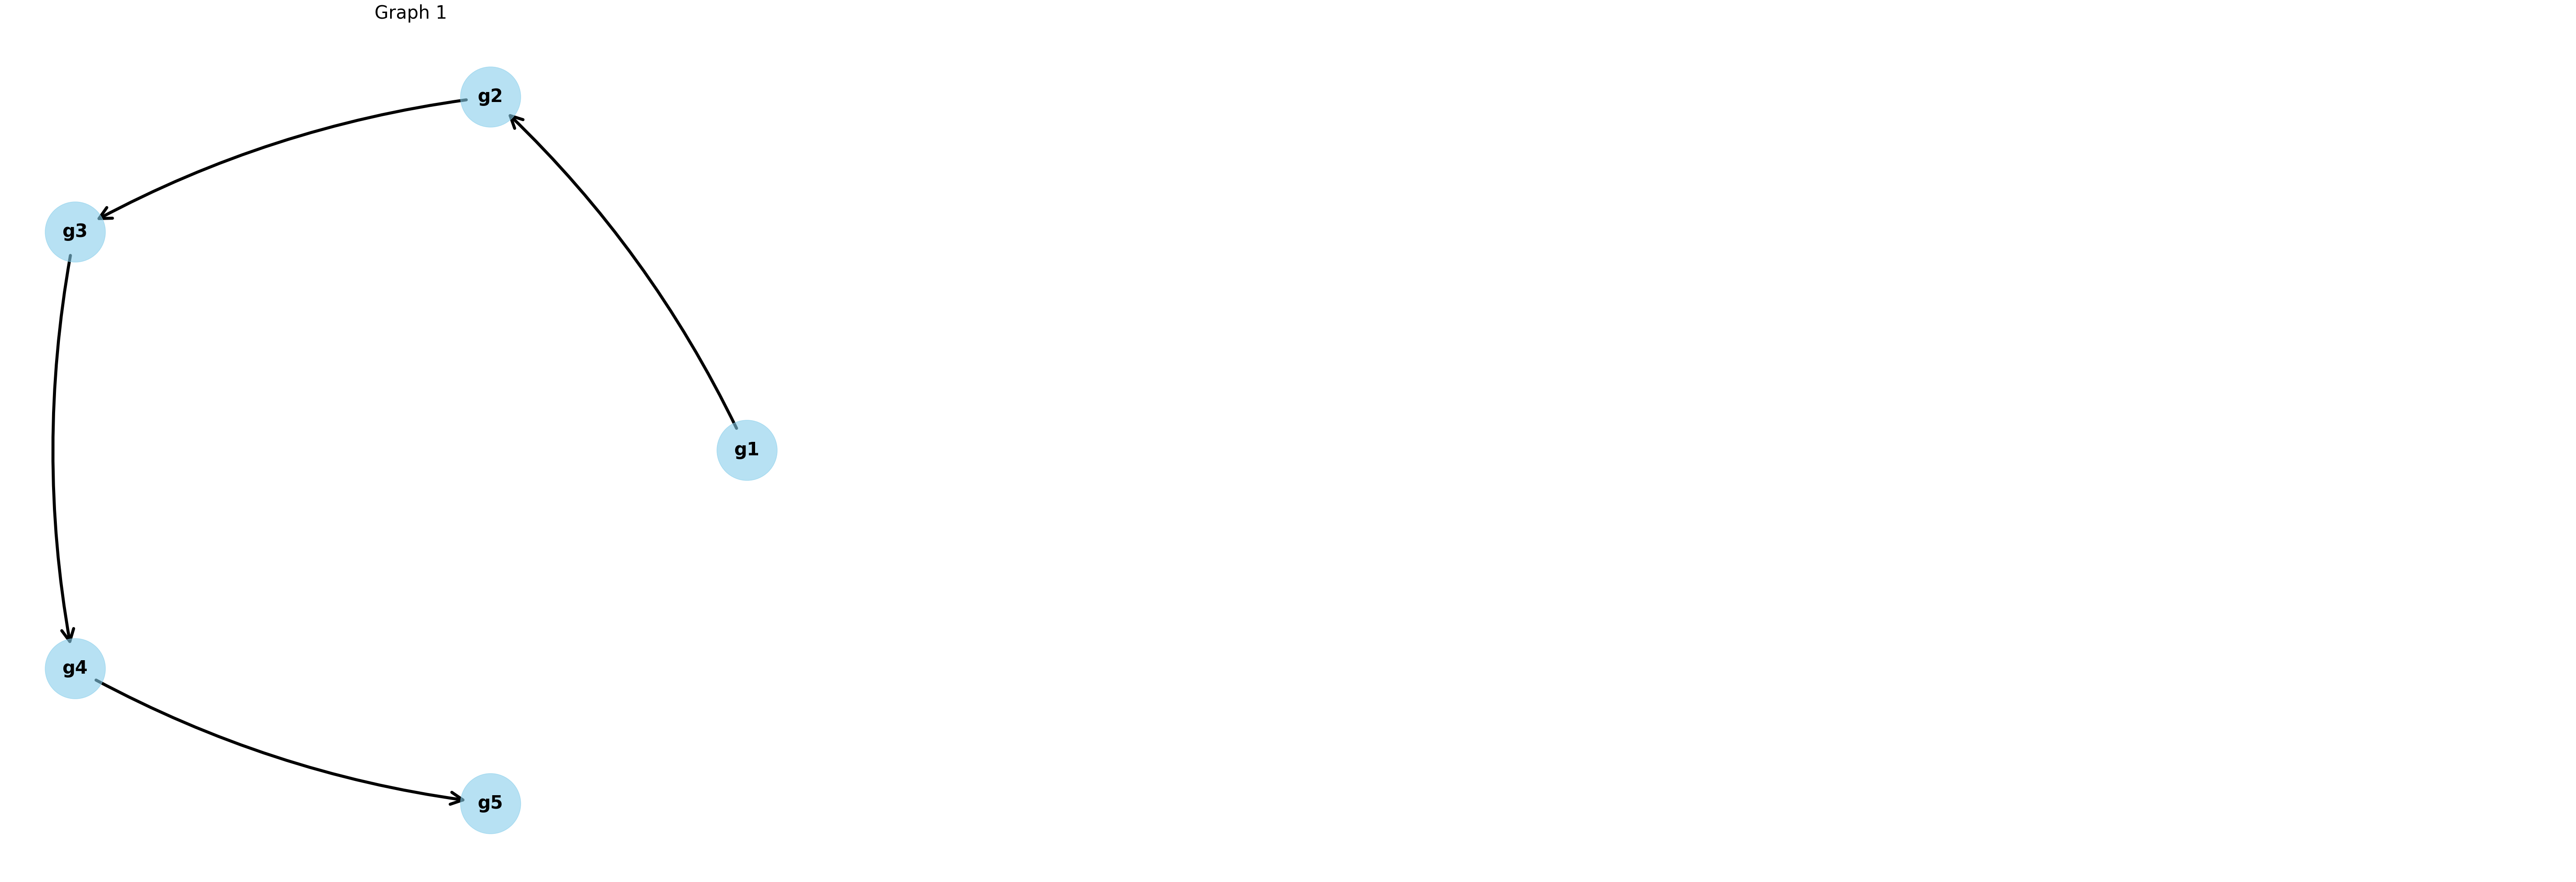

In [10]:
numNodes = 5
maxEdges = numNodes*(numNodes - 1) + 1
initialStateCreated = 0
numNodeList = np.array([5])
if __name__ == "__main__":
    graphs = createLinearGraph(numNodeList)
    for i in graphs:
        initialState = prepareInitialState(i.nodes)
        graphFolder = f"/home/mzo5929/Keerthana/GRNsimulation/highthroughputData/linearNetworksSimulationSetup/moreLinearNetworkSimulationSetup/graph{len(i.nodes)}"
        # os.makedirs(graphFolder)
        # initialState.to_csv(f"{graphFolder}/initialStates.csv")
        # saveGraphsAsGml(i, graphFolder)

## To subsample the parameter space to get a number of parameter sets

In [ ]:
import numpy as np
from scipy.stats import qmc
seed = 42
# Define the original bounds
lowerBounds = [0.01, 0.001, 0.001, 0.01, 2, 0.1, 0.1]
upperBounds = [1, 0.1, 0.1, 0.1, 100, 1, 10]

# Convert bounds to log scale
logLowerBounds = np.log10(lowerBounds)
logUpperBounds = np.log10(upperBounds)

# Create a Latin Hypercube Sampler in the log scale space
sampler = qmc.LatinHypercube(d=7, optimization="random-cd", seed= seed)
logSample = sampler.random(n=3500)

# Scale samples within the log scale bounds
scaledLogParameters = qmc.scale(logSample, logLowerBounds, logUpperBounds)

# Convert scaled log samples back to original scale
scaledParameters = 10**scaledLogParameters  # Use the base of the log transformation used for bounds

# Check some of the results
print("Scaled parameters (original scale):")
print(scaledParameters[:5])  # Print the first 5 samples to check


In [ ]:
sample = sampler.random(n=500)
scaledParametersOther = qmc.scale(sample, lowerBounds, upperBounds)

In [ ]:
scaledParameters

In [ ]:
import pandas as pd

In [ ]:
colNames = ["rProd", "rDeg", "rOn", "rOff", "d", "rAdd", "n"]
scaledParametersDf = pd.DataFrame(scaledParameters, columns=colNames)
fullParameterSet = []

for i in [0.5, 0.75, 0.95]:
    # Create a copy to avoid modifying the original DataFrame
    tempDf = scaledParametersDf.copy()
    # Calculate 'k' and add it to the copy
    tempDf['k'] = i * tempDf['rProd'] * tempDf['d'] / tempDf['rDeg']
    # Append the modified DataFrame to the list
    fullParameterSet.append(tempDf)

# Concatenate all DataFrames in the list into one
parameterDf = pd.concat(fullParameterSet, ignore_index=True)

parameterDf.to_csv("/home/mzo5929/Keerthana/GRNsimulation/highthroughputData/parameterSets/parameterSet_26Nov2024.csv")

In [ ]:
parameterDf.iloc[0]

In [ ]:
parameterDf.iloc[7000]

In [ ]:
scaledParametersDf = pd.read_csv("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/KeerthanaArun/grnInference/grnSimulationSetup/highthroughputData/parameterSets/logRanges2020Parameters500Seed42.csv", index_col=0)

In [ ]:
scaledParametersDf
colNames = scaledParametersDf.columns.tolist()


In [ ]:
# Select a parameter to plot, for example, the first parameter (index 0)
for parameter_index in np.arange(0, 7):
    # parameter_index = 0
    parameter_samples = scaledParametersDf.iloc[:, parameter_index]

    # Plotting on a linear scale
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    bins = np.logspace(np.log10(min(parameter_samples)), np.log10(max(parameter_samples)), 50)

    # Plot histogram with log-scaled bins
    plt.hist(parameter_samples, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f'Linear Scale: {colNames[parameter_index]}')
    plt.xlabel('Parameter Value')
    plt.ylabel('Frequency')

    # Plotting on a logarithmic scale
    plt.subplot(1, 2, 2)
    plt.hist(parameter_samples,  bins=bins, color='skyblue', log=True)
    plt.xscale('log')
    plt.title(f'Log Scale: {colNames[parameter_index]}')
    plt.xlabel('Parameter Value')
    plt.ylabel('Log Frequency')

    # Show the plot
    plt.tight_layout()
    plt.show()


# Other code

Implementing the algorithm by hand (thanks to ChatGPT) to understand how isomorphism tests is definitely working

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import hashlib

def hash_label(label):
    """Create a short hash of a given label."""
    hash = hashlib.sha256(label.encode()).hexdigest()
    print(len(hash))
    return hash[:8]
    # return label

def plot_graph(graph, labels, title):
    """Plot a graph with node labels."""
    pos = nx.spring_layout(graph)  # positions for all nodes
    nx.draw_networkx_nodes(graph, pos,  node_size=400, node_color='lightblue')
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=12)
    plt.title(title)

    for u, v in graph.edges():
        if graph.has_edge(v, u):
            # Draw bi-directional edges with a curve
            nx.draw_networkx_edges(graph, pos,  edgelist=[(u, v)], arrows=True,
                                       connectionstyle='arc3,rad=0.2', arrowstyle='-|>', style='solid')
        else:
            # Draw normal directed edges
            nx.draw_networkx_edges(graph, pos, edgelist=[(u, v)], arrows=True,
                                    connectionstyle='arc3,rad=0.0', arrowstyle='-|>', style='solid')

    plt.show()

def weisfeiler_lehman_graph_hash(graph, iterations=2):
    """Apply Weisfeiler-Lehman graph hashing algorithm and visualize at each step."""
    G = nx.DiGraph()

# Add directed edges to the graph
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)  # Creates a directed edge from 'node' to 'neighbor'


    # Initialize labels
    labels = {node: "0" for i, node in enumerate(graph)}
    plot_graph(G, labels, "Initial Labels")

    for i in range(iterations):
        new_labels = {}
        for node, neighbors in graph.items():
            # Aggregate labels from neighbors
            neighbor_labels = sorted([labels[neighbor] for neighbor in neighbors])
            # Concatenate current label with neighbor labels and hash
            new_label = hash_label(labels[node] + "".join(neighbor_labels))
            new_labels[node] = new_label
        labels = new_labels
        plot_graph(G, labels, f"Labels after iteration {i+1}")

    # Combine all labels for a graph hash
    all_labels = sorted(labels.values())
    graph_label = hash_label("".join(all_labels))
    print("graph_label ", graph_label, "labels ", labels)
    return graph_label, labels

# Example graph: A -- B -- C
graph1 = {
    'A': ['B', 'C'],
    'B': ['A', 'C'],
    'C': ['B']
}

graph2 = {
    'B': ['C', 'A'],
    'A': ['C'],
    'C': ['B', 'A']
}

weisfeiler_lehman_graph_hash(graph1, iterations=2)
weisfeiler_lehman_graph_hash(graph2, iterations=2)



Old visualisation script

In [ ]:
# def visualize_graphs(graphs, per_row=3):
  
  # total = len(graphs)
    # rows = (total + per_row - 1) // per_row  # Calculate the required number of rows
    # fig, axes = plt.subplots(rows, per_row, figsize=(per_row * 6, rows * 6))  # Increased figure size
    
    # if rows > 1:
    #     axes = axes.flatten()  # Flatten the axes array for easier indexing
    # elif rows == 1:
    #     axes = [axes]  # Ensure axes is iterable even for a single row

    # for i, ax in enumerate(axes):
    #     if i < total:
    #         G = graphs[i]
    #         pos = nx.kamada_kawai_layout(G)  # Using an alternative layout that might spread nodes more evenly
    #         # Scale positions manually to increase edge lengths
    #         pos = {node: (x * 2, y * 2) for node, (x, y) in pos.items()}

    #         nx.draw_networkx_nodes(G, pos, ax=ax, node_color='skyblue', node_size=500, alpha=0.6)
    #         nx.draw_networkx_labels(G, pos, ax=ax, font_size=12, font_weight='bold')

    #         for u, v in G.edges():
    #             if G.has_edge(v, u):
    #                 nx.draw_networkx_edges(G, pos, ax=ax, edgelist=[(u, v)], arrows=True,
    #                                        connectionstyle='arc3,rad=0.2', arrowstyle='-|>', style='dashed', alpha=0.5)
    #             else:
    #                 nx.draw_networkx_edges(G, pos, ax=ax, edgelist=[(u, v)], arrows=True,
    #                                        connectionstyle='arc3,rad=0.0', arrowstyle='-|>', style='solid')

    #         ax.set_title(f'Graph {i+1}')
    #     ax.axis('off')  # Hide axes for unused subplots

    # plt.tight_layout()
    # plt.show()